✅ Detected one hand.

📏 Distance between Thumb Tip (LM_4) and Index Tip (LM_8):
   → Normalized distance: 0.4425
   → Pixel distance: 213.79 pixels



C:\Users\shrey\miniconda3\envs\cv_env\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


,name,x_norm,y_norm,z_norm,x_px,y_px
index,,,,,,
0,WRIST,0.302507,0.809336,0.000001,193,388
1,THUMB_CMC,0.420119,0.862222,-0.068023,268,413
2,THUMB_MCP,0.550761,0.845684,-0.097091,352,405
3,THUMB_IP,0.656765,0.804836,-0.117276,420,386
4,THUMB_TIP,0.745987,0.776397,-0.135819,477,372
5,INDEX_MCP,0.588572,0.574734,-0.051079,376,275
6,INDEX_PIP,0.693103,0.471194,-0.087437,443,226
7,INDEX_DIP,0.759904,0.401771,-0.120828,486,192
8,INDEX_TIP,0.816975,0.339710,-0.145566,522,163


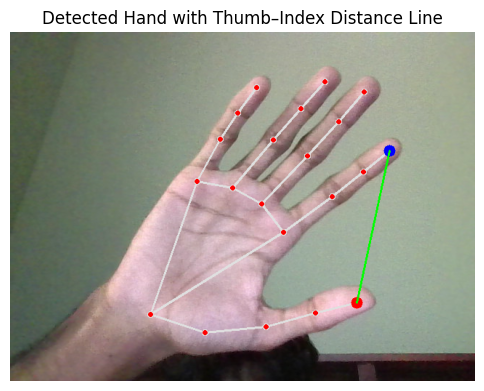

In [4]:
# --- Auto-install required libraries (run only if missing) ---
try:
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip install mediapipe opencv-python pandas matplotlib
    import mediapipe as mp
    import cv2
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

# --- Setup ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2
)

# Landmark names for clarity
LANDMARK_NAMES = {
    0: "WRIST",
    1: "THUMB_CMC",
    2: "THUMB_MCP",
    3: "THUMB_IP",
    4: "THUMB_TIP",
    5: "INDEX_MCP",
    6: "INDEX_PIP",
    7: "INDEX_DIP",
    8: "INDEX_TIP",
    9: "MIDDLE_MCP",
    10: "MIDDLE_PIP",
    11: "MIDDLE_DIP",
    12: "MIDDLE_TIP",
    13: "RING_MCP",
    14: "RING_PIP",
    15: "RING_DIP",
    16: "RING_TIP",
    17: "PINKY_MCP",
    18: "PINKY_PIP",
    19: "PINKY_DIP",
    20: "PINKY_TIP",
}

# --- Capture one frame from webcam ---
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Unable to read from the webcam (device 0). Check camera connection.")

# Mirror for a natural webcam view
frame = cv2.flip(frame, 1)
img_h, img_w = frame.shape[:2]

# Convert BGR → RGB (MediaPipe expects RGB)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# --- Run MediaPipe Hands ---
results = hands.process(frame_rgb)

if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
    # Take first detected hand
    hand_landmarks = results.multi_hand_landmarks[0]

    # Store landmarks in a table
    rows = []
    for idx, lm in enumerate(hand_landmarks.landmark):
        x_norm, y_norm, z_norm = lm.x, lm.y, lm.z
        x_px, y_px = int(x_norm * img_w), int(y_norm * img_h)
        rows.append({
            "index": idx,
            "name": LANDMARK_NAMES.get(idx, f"LM_{idx}"),
            "x_norm": x_norm,
            "y_norm": y_norm,
            "z_norm": z_norm,
            "x_px": x_px,
            "y_px": y_px
        })

    df = pd.DataFrame(rows).set_index("index")

    # ---- Calculate Thumb–Index Tip Distance ----
    thumb_tip = df.loc[4]   # THUMB_TIP
    index_tip = df.loc[8]   # INDEX_TIP

    # Normalized distance
    norm_dist = np.sqrt(
        (thumb_tip["x_norm"] - index_tip["x_norm"])**2 +
        (thumb_tip["y_norm"] - index_tip["y_norm"])**2 +
        (thumb_tip["z_norm"] - index_tip["z_norm"])**2
    )

    # Pixel distance (2D)
    pixel_dist = np.sqrt(
        (thumb_tip["x_px"] - index_tip["x_px"])**2 +
        (thumb_tip["y_px"] - index_tip["y_px"])**2
    )

    print("✅ Detected one hand.\n")
    print(f"📏 Distance between Thumb Tip (LM_4) and Index Tip (LM_8):")
    print(f"   → Normalized distance: {norm_dist:.4f}")
    print(f"   → Pixel distance: {pixel_dist:.2f} pixels\n")

    # Display landmark table
    display(df)

    # Draw landmarks on image
    annotated = frame.copy()
    mp_drawing.draw_landmarks(annotated, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Highlight Thumb Tip and Index Tip points
    cv2.circle(annotated, (thumb_tip["x_px"], thumb_tip["y_px"]), 8, (0, 0, 255), -1)
    cv2.circle(annotated, (index_tip["x_px"], index_tip["y_px"]), 8, (255, 0, 0), -1)
    cv2.line(annotated,
             (thumb_tip["x_px"], thumb_tip["y_px"]),
             (index_tip["x_px"], index_tip["y_px"]),
             (0, 255, 0), 2)

    # Show annotated image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.title("Detected Hand with Thumb–Index Distance Line")
    plt.axis("off")
    plt.show()

else:
    print("⚠️ No hand detected. Try showing your hand clearly to the webcam and re-run the cell.")

# Clean up
hands.close()


In [5]:
import time
import math
import cv2
import mediapipe as mp
import numpy as np

# --- Configuration ---
CAM_INDEX = 0                # webcam device index
PRINT_EVERY_N_FRAMES = 10    # console print frequency (reduce if you don't want too many prints)
PINCH_PIXEL_THRESHOLD = 40   # pixel threshold to consider "pinch" (tune for your camera/resolution)
PINCH_NORM_THRESHOLD = 0.03  # normalized distance threshold for pinch (tune if needed)

# --- Initialize MediaPipe Hands ---
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2
)

cap = cv2.VideoCapture(CAM_INDEX)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open camera index {CAM_INDEX}")

frame_count = 0
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to read frame from camera. Exiting.")
            break

        # Mirror frame for a natural webcam view
        frame = cv2.flip(frame, 1)
        img_h, img_w = frame.shape[:2]

        # Convert to RGB and process
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        # Default display values
        pixel_dist = None
        norm_dist = None
        pinch = False
        handedness_label = None

        if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
            # Use the first detected hand (index 0)
            hand_landmarks = results.multi_hand_landmarks[0]

            # Get landmark 4 (thumb tip) and 8 (index tip)
            lm_thumb = hand_landmarks.landmark[4]
            lm_index = hand_landmarks.landmark[8]

            # Normalized euclidean distance (3D)
            dx_n = lm_thumb.x - lm_index.x
            dy_n = lm_thumb.y - lm_index.y
            dz_n = lm_thumb.z - lm_index.z
            norm_dist = math.sqrt(dx_n*dx_n + dy_n*dy_n + dz_n*dz_n)

            # Pixel distance (2D) using image size
            tx_px = int(round(lm_thumb.x * img_w))
            ty_px = int(round(lm_thumb.y * img_h))
            ix_px = int(round(lm_index.x * img_w))
            iy_px = int(round(lm_index.y * img_h))
            pixel_dist = math.hypot(tx_px - ix_px, ty_px - iy_px)

            # Determine pinch by simple threshold (either pixel or normalized)
            if pixel_dist <= PINCH_PIXEL_THRESHOLD or norm_dist <= PINCH_NORM_THRESHOLD:
                pinch = True

            # Draw landmarks and the connecting line
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Highlight thumb tip and index tip
            cv2.circle(frame, (tx_px, ty_px), 8, (0, 0, 255), -1)   # thumb: red
            cv2.circle(frame, (ix_px, iy_px), 8, (255, 0, 0), -1)   # index: blue
            cv2.line(frame, (tx_px, ty_px), (ix_px, iy_px), (0, 255, 0), 2)  # connecting line

            # If handedness is available, show label for the first hand
            if results.multi_handedness and len(results.multi_handedness) > 0:
                try:
                    handedness_label = results.multi_handedness[0].classification[0].label
                except Exception:
                    handedness_label = None

        # Overlay text on the frame
        y0 = 30
        dy = 28
        overlay_texts = []
        if handedness_label:
            overlay_texts.append(f"Hand: {handedness_label}")
        if norm_dist is not None:
            overlay_texts.append(f"Norm dist: {norm_dist:.4f}")
        if pixel_dist is not None:
            overlay_texts.append(f"Pixel dist: {pixel_dist:.1f}px")
        overlay_texts.append(f"Pinch: {'YES' if pinch else 'no'} (th={PINCH_PIXEL_THRESHOLD}px)")

        for i, t in enumerate(overlay_texts):
            cv2.putText(frame, t, (10, y0 + i*dy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2.imshow("Hand Distance (press 'q' to quit)", frame)

        # Print to console every N frames
        if frame_count % PRINT_EVERY_N_FRAMES == 0:
            ts = time.strftime("%H:%M:%S")
            if norm_dist is None:
                print(f"[{ts}] No hand detected")
            else:
                print(f"[{ts}] Norm dist={norm_dist:.4f}  Pixel dist={pixel_dist:.1f}px  Pinch={'YES' if pinch else 'no'}")

        frame_count += 1

        # Exit on 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    hands.close()
    print("Clean exit.")


[11:47:54] No hand detected


C:\Users\shrey\miniconda3\envs\cv_env\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


[11:47:55] Norm dist=0.4078  Pixel dist=195.1px  Pinch=no
[11:47:56] Norm dist=0.4177  Pixel dist=200.0px  Pinch=no
[11:47:57] Norm dist=0.3883  Pixel dist=186.2px  Pinch=no
[11:47:57] Norm dist=0.3848  Pixel dist=185.2px  Pinch=no
[11:47:58] Norm dist=0.2439  Pixel dist=118.7px  Pinch=no
[11:47:59] Norm dist=0.3746  Pixel dist=180.5px  Pinch=no
[11:47:59] Norm dist=0.4483  Pixel dist=216.7px  Pinch=no
[11:48:00] Norm dist=0.4534  Pixel dist=218.7px  Pinch=no
[11:48:01] Norm dist=0.3520  Pixel dist=168.9px  Pinch=no
[11:48:01] Norm dist=0.3654  Pixel dist=175.6px  Pinch=no
[11:48:02] Norm dist=0.2940  Pixel dist=144.1px  Pinch=no
[11:48:03] Norm dist=0.2795  Pixel dist=136.6px  Pinch=no
[11:48:03] Norm dist=0.2474  Pixel dist=120.1px  Pinch=no
[11:48:04] Norm dist=0.2777  Pixel dist=132.7px  Pinch=no
[11:48:04] Norm dist=0.2896  Pixel dist=138.9px  Pinch=no
[11:48:05] Norm dist=0.3118  Pixel dist=150.5px  Pinch=no
[11:48:06] Norm dist=0.3050  Pixel dist=146.1px  Pinch=no
[11:48:06] Nor

C:\Users\shrey\AppData\Local\Temp\ipykernel_9852\580035768.py:159: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pix_arr) > 0 and np.nanmax(norm_arr) > 0:


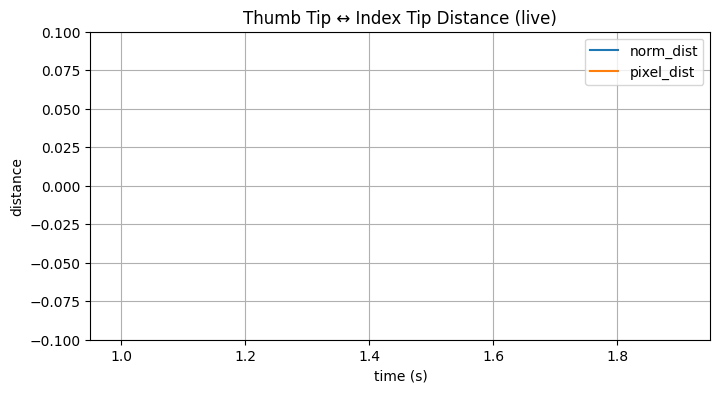

[11:49:35] no hand
[11:49:37] no hand
[11:49:39] norm=0.3935  pix=190.4px  pinch=no
[11:49:41] norm=0.0403  pix=19.1px  pinch=YES
[11:49:42] norm=0.2327  pix=109.3px  pinch=no
[11:49:44] norm=0.1221  pix=58.4px  pinch=no
[11:49:46] norm=0.2250  pix=108.3px  pinch=no
[11:49:47] norm=0.5244  pix=252.0px  pinch=no
[11:49:49] norm=0.6256  pix=300.6px  pinch=no
[11:49:51] norm=0.5425  pix=266.3px  pinch=no
[11:49:53] norm=0.5555  pix=272.3px  pinch=no
Clean exit.


In [6]:
"""
hand_distance_live_plot.py

Real-time hand landmark distance + live plot.

Requirements:
    pip install mediapipe opencv-python matplotlib numpy
"""

import time
import math
from collections import deque
import csv
import os

import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Configuration ----------------
CAM_INDEX = 0
MAX_PTS = 200                 # number of points shown on the live plot (rolling window)
PRINT_EVERY_N_FRAMES = 15     # console print frequency
PINCH_PIXEL_THRESHOLD = 40
PINCH_NORM_THRESHOLD = 0.03

LOG_TO_CSV = True             # toggle CSV logging
CSV_FILENAME = "hand_distance_log.csv"
# ------------------------------------------------

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2
)

# Initialize webcam
cap = cv2.VideoCapture(CAM_INDEX)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open camera index {CAM_INDEX}")

# Prepare data structures for live plotting
timestamps = deque(maxlen=MAX_PTS)
norm_dists = deque(maxlen=MAX_PTS)
pixel_dists = deque(maxlen=MAX_PTS)

# Prepare matplotlib figure
plt.ion()
fig, ax = plt.subplots(figsize=(8, 4))
line_norm, = ax.plot([], [], label="norm_dist")   # do not set colors explicitly
line_pix, = ax.plot([], [], label="pixel_dist")
ax.set_xlabel("time (s)")
ax.set_ylabel("distance")
ax.set_title("Thumb Tip ↔ Index Tip Distance (live)")
ax.legend(loc="upper right")
ax.grid(True)

start_time = time.time()
frame_count = 0

# Prepare CSV log
if LOG_TO_CSV:
    first_write = not os.path.exists(CSV_FILENAME)
    csv_file = open(CSV_FILENAME, "a", newline="")
    csv_writer = csv.writer(csv_file)
    if first_write:
        csv_writer.writerow(["timestamp_iso", "elapsed_s", "norm_dist", "pixel_dist", "pinch"])

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to read frame from camera. Exiting.")
            break

        frame = cv2.flip(frame, 1)
        img_h, img_w = frame.shape[:2]
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(frame_rgb)

        norm_dist = None
        pixel_dist = None
        pinch = False
        handedness_label = None

        if results.multi_hand_landmarks and len(results.multi_hand_landmarks) > 0:
            # use first detected hand (index 0)
            hand_landmarks = results.multi_hand_landmarks[0]
            lm_thumb = hand_landmarks.landmark[4]
            lm_index = hand_landmarks.landmark[8]

            dx_n = lm_thumb.x - lm_index.x
            dy_n = lm_thumb.y - lm_index.y
            dz_n = lm_thumb.z - lm_index.z
            norm_dist = math.sqrt(dx_n*dx_n + dy_n*dy_n + dz_n*dz_n)

            tx_px = int(round(lm_thumb.x * img_w))
            ty_px = int(round(lm_thumb.y * img_h))
            ix_px = int(round(lm_index.x * img_w))
            iy_px = int(round(lm_index.y * img_h))
            pixel_dist = math.hypot(tx_px - ix_px, ty_px - iy_px)

            if pixel_dist <= PINCH_PIXEL_THRESHOLD or (norm_dist is not None and norm_dist <= PINCH_NORM_THRESHOLD):
                pinch = True

            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            cv2.circle(frame, (tx_px, ty_px), 8, (0, 0, 255), -1)
            cv2.circle(frame, (ix_px, iy_px), 8, (255, 0, 0), -1)
            cv2.line(frame, (tx_px, ty_px), (ix_px, iy_px), (0, 255, 0), 2)

            if results.multi_handedness and len(results.multi_handedness) > 0:
                try:
                    handedness_label = results.multi_handedness[0].classification[0].label
                except Exception:
                    handedness_label = None

        # overlay text
        base_y = 25
        dy_text = 26
        lines = []
        if handedness_label:
            lines.append(f"Hand: {handedness_label}")
        if norm_dist is not None:
            lines.append(f"Norm: {norm_dist:.4f}")
        if pixel_dist is not None:
            lines.append(f"Pixel: {pixel_dist:.1f}px")
        lines.append(f"Pinch: {'YES' if pinch else 'no'}")

        for i, txt in enumerate(lines):
            cv2.putText(frame, txt, (10, base_y + i*dy_text), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

        cv2.imshow("Hand Distance (press 'q' to quit)", frame)

        # update data buffers
        elapsed = time.time() - start_time
        timestamps.append(elapsed)
        norm_dists.append(norm_dist if norm_dist is not None else np.nan)
        pixel_dists.append(pixel_dist if pixel_dist is not None else np.nan)

        # update plot lines (convert deques to arrays)
        t_arr = np.array(timestamps)
        norm_arr = np.array(norm_dists)
        pix_arr = np.array(pixel_dists)

        # keep x axis relative to current time window
        if len(t_arr) > 0:
            xmin = t_arr[0]
            xmax = t_arr[-1]
            ax.set_xlim(xmin, xmax if xmax > xmin else xmin + 1)

        # scale pixel distances to overlay with normalized values on same axis for visibility:
        # compute scale factor only when we have values
        if np.nanmax(pix_arr) > 0 and np.nanmax(norm_arr) > 0:
            # map pixel max to ~ (norm max * factor)
            # choose factor so both series are visible; if pixel magnitudes are large, downscale them
            # simple heuristic:
            factor = (np.nanmax(norm_arr) + 1e-6) / (np.nanmax(pix_arr) + 1e-6)
        else:
            factor = 1.0

        scaled_pix = pix_arr * factor

        # update plotted data
        line_norm.set_data(t_arr, norm_arr)
        line_pix.set_data(t_arr, scaled_pix)

        # recompute y-limits to fit data
        y_vals = np.concatenate([np.nan_to_num(norm_arr, nan=0.0), np.nan_to_num(scaled_pix, nan=0.0)])
        if y_vals.size > 0:
            y_min, y_max = np.min(y_vals), np.max(y_vals)
            padding = (y_max - y_min) * 0.1 if (y_max - y_min) > 0 else 0.1
            ax.set_ylim(y_min - padding, y_max + padding)

        ax.relim()
        ax.autoscale_view()  # ensure view updated
        fig.canvas.draw()
        fig.canvas.flush_events()
        plt.pause(0.001)  # keep UI responsive

        # optional CSV logging
        if LOG_TO_CSV:
            iso_ts = time.strftime("%Y-%m-%dT%H:%M:%S", time.localtime())
            csv_writer.writerow([
                iso_ts,
                f"{elapsed:.3f}",
                f"{(norm_dist if norm_dist is not None else '')}",
                f"{(pixel_dist if pixel_dist is not None else '')}",
                "1" if pinch else "0"
            ])
            # flush file occasionally
            if frame_count % 50 == 0:
                csv_file.flush()

        # occasional console print
        if frame_count % PRINT_EVERY_N_FRAMES == 0:
            now = time.strftime("%H:%M:%S")
            if norm_dist is None:
                print(f"[{now}] no hand")
            else:
                print(f"[{now}] norm={norm_dist:.4f}  pix={pixel_dist:.1f}px  pinch={'YES' if pinch else 'no'}")

        frame_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    hands.close()
    if LOG_TO_CSV:
        csv_file.close()
    print("Clean exit.")


In [7]:
!python hand_distance_live_plot.py


Figure(800x400)
[11:58:55] no hand
[11:58:57] no hand
[11:58:58] no hand
[11:59:00] norm=0.4562  pix=219.4px  pinch=no
[11:59:02] norm=0.0542  pix=22.0px  pinch=YES
[11:59:04] norm=0.4615  pix=221.3px  pinch=no
[11:59:05] norm=0.2078  pix=97.3px  pinch=no
[11:59:07] norm=0.6868  pix=344.8px  pinch=no
[11:59:09] norm=0.0698  pix=33.4px  pinch=YES
[11:59:11] norm=0.5195  pix=253.0px  pinch=no
[11:59:13] norm=0.0701  pix=19.7px  pinch=YES
Clean exit.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1762410532.775086   11600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762410532.802891   12120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
C:\Users\shrey\hand_distance_live_plot.py:155: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(pix_arr) > 0 and np.nanmax(norm_arr) > 0:
C:\Users\shrey\miniconda3\envs\cv_env\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
